In [3]:
# example of loading the fashion_mnist dataset

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import numpy as np
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.datasets.fashion_mnist import load_data
from keras.utils import plot_model

from ann_visualizer.visualize import ann_viz


import cv2



#matploti
import matplotlib.pyplot as plt

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Using TensorFlow backend.


Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [11]:
trainX[0].shape

(28, 28)

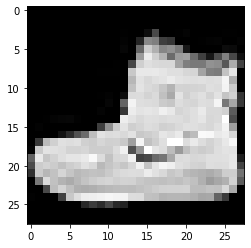

In [3]:
plt.imshow(trainX[0], cmap='gray')

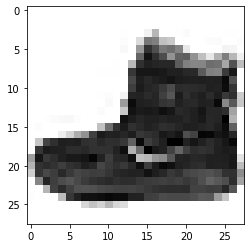

In [12]:
# plot raw pixel data gray reversed
plt.imshow(trainX[0], cmap='gray_r')

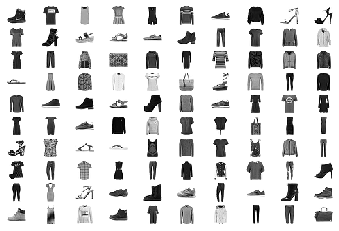

In [13]:
# plot images from the training dataset
for i in range(100):
	# define subplot
	plt.subplot(10, 10, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [26]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    

In [27]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

In [28]:
def define_gan(discriminator,generator):
    
    
    discriminator.trainable = False
    
    model = Sequential()
    
    
    model.add(generator)
    
    
    model.add(discriminator)
    
    
    opt= Adam(lr=0.0002,beta_1=0.5)
    
    model.compile(loss='binary_crossentropy',optimizer=opt)
    
    return model

In [29]:
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [35]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [36]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [37]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    for i in range(n_samples):
        # define subplot
        plt.subplot(10, 10, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(np.squeeze(X[i]), cmap='gray_r')
    plt.show()
    return X, y

In [40]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)# manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('generator.h5')


C:\Users\nosco\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


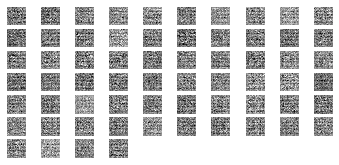

C:\Users\nosco\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=0.707, d2=0.694 g=0.692


C:\Users\nosco\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


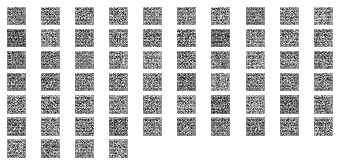

>1, 2/468, d1=0.637, d2=0.698 g=0.689


KeyboardInterrupt: 

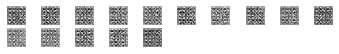

In [41]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(discriminator, generator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)


gan_model.save('gan.h5')
generator.save('generator.h5')
discriminator.save('disc.h5')

(275, 350, 3)
(275, 350, 3)


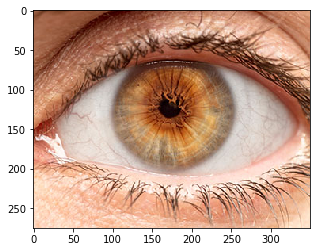

In [37]:
im = cv2.imread("eye.jpg")
print(im.shape)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)
plt.imshow(im)
plt.show()
